In [50]:
#import qiskit tools
import qiskit
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, transpile, Aer, IBMQ
from qiskit.tools.visualization import circuit_drawer
from qiskit.visualization import plot_histogram
from qiskit.tools.monitor import job_monitor, backend_monitor, backend_overview
from qiskit.providers.aer import noise

#import python stuff
import matplotlib.pyplot as plt
import numpy as np
import time

# Set backend device, choose to use a simulator
sim = Aer.get_backend('aer_simulator')

# functions..............................................................................................
def make_chsh_circuit(theta_vec):
    """Return a list of QuantumCircuits for use in a CHSH experiemnt
    (one circuit for each value of theta in theta_vec)
    (theta is the angle between the bases of Alice and Bob)
    
        Args:
            theta_vec (list): list of values of angles between the bases of Alice and Bob
        
        Returns:
            List[QuantumCircuit]: CHSH QuantumCircuits for each value of theta
    """
    chsh_circuits = []
    
    for theta in theta_vec:
        obs_vec = ['00', '01', '10', '11'] # observed_vector? ex: '01' means 1st measurement got 0, second got 1
        for el in obs_vec:
            qc = QuantumCircuit(2,2) # create a quantum circuit with two quantum register(qubits) and two classical register
            qc.h(0) # add a H gate on qubit 0
            qc.cx(0, 1) # Add a CX (CNOT) gate on control qubit 0 and target qubit 1
            qc.ry(theta, 0) # rotate around y-axis by theta
            for a in range(2): # what does this do? why do we need this part?
                if el[a] == '1':
                    qc.h(a)
            qc.measure(range(2),range(2)) # measure q0 save to bit_0, then measure q1 save to bit_1
            chsh_circuits.append(qc)

    return chsh_circuits

def compute_chsh_witness(counts):
    """Computes expectation values for the CHSH inequality, for each
    angle (theta) between measurement axis.

        Args: counts (list[dict]): dict of counts for each experiment
              (4 per value of theta)

        Returns:
            Tuple(List, List): Tuple of lists with the two CHSH witnesses
    """
    # Order is ZZ,ZX,XZ,XX
    
    CHSH1 = []
    CHSH2 = []
    # Divide the list of dictionaries in sets of 4
    for i in range(0, len(counts), 4):  
        theta_dict = counts[i:i + 4]
        zz = theta_dict[0] # alice uses z basis, bob uses z basis, which is the same as a and b measurement.
        zx = theta_dict[1] # a and b'
        xz = theta_dict[2]
        xx = theta_dict[3]

        no_shots = sum(xx[y] for y in xx)

        chsh1 = 0
        chsh2 = 0

        # E(a,b)
        for element in zz:  # zz is a dict
            parity = (-1)**(int(element[0])+int(element[1])) 
            chsh1+= parity*zz[element]
            chsh2+= parity*zz[element]

        #E(a,b')
        for element in zx:
            parity = (-1)**(int(element[0])+int(element[1]))
            chsh1+= parity*zx[element]
            chsh2-= parity*zx[element]

        #E(a',b)
        for element in xz:
            parity = (-1)**(int(element[0])+int(element[1]))
            chsh1-= parity*xz[element]
            chsh2+= parity*xz[element]

        # E(a',b')
        for element in xx:
            parity = (-1)**(int(element[0])+int(element[1]))
            chsh1+= parity*xx[element]
            chsh2+= parity*xx[element]

        CHSH1.append(chsh1/no_shots)
        CHSH2.append(chsh2/no_shots)
    
    return CHSH1 #return the S of each circuit
# functions...........................................................................................

#split 0 to 2pi into 15 angles. use these angles to build the chsh circuit
number_of_thetas = 15
theta_vec = np.linspace(0,2*np.pi,number_of_thetas)
my_chsh_circuits = make_chsh_circuit(theta_vec)

# test and see the circuit: the circuits create a bell pair, and measure them in different basis. 
# Bob(q1) in +,-,0,1 state, Alice(q0) in theta respected to Bob
# my_chsh_circuits[5].draw()

# Execute and get counts
result_ideal = sim.run(my_chsh_circuits).result()
counts_ideal = result_ideal.get_counts()
CHSH1_ideal = compute_chsh_witness(counts_ideal) # this is the S value

# use snspd data to modify the counts
snspd_counts = []
for i in range(0,len(counts_ideal)):
    if ('00' in counts_ideal[i]) == False:
        counts_ideal[i]['00'] = 0
    if ('01' in counts_ideal[i]) == False:
        counts_ideal[i]['01'] = 0
    if ('10' in counts_ideal[i]) == False:
        counts_ideal[i]['10'] = 0
    if ('11' in counts_ideal[i]) == False:
        counts_ideal[i]['11'] = 0
    snspd_counts.append({})
    snspd_counts[i]['00'] = counts_ideal[i]['00']*0.78*0.78 + counts_ideal[i]['10']*0.0035*0.78 + counts_ideal[i]['01']*0.0035*0.78 + counts_ideal[i]['11']*0.0035*0.0035
    snspd_counts[i]['10'] = counts_ideal[i]['00']*0.0035*0.78 + counts_ideal[i]['10']*0.81*0.78 + counts_ideal[i]['01']*0.027*0.0035 + counts_ideal[i]['11']*0.81*0.0035
    snspd_counts[i]['01'] = counts_ideal[i]['00']*0.0035*0.78 + counts_ideal[i]['10']*0.0035*0.027 + counts_ideal[i]['01']*0.78*0.81 + counts_ideal[i]['11']*0.81*0.0035
    snspd_counts[i]['11'] = counts_ideal[i]['00']*0.027*0.027 + counts_ideal[i]['10']*0.81*0.027 + counts_ideal[i]['01']*0.027*0.81 + counts_ideal[i]['11']*0.81*0.81
print(counts_ideal)  
print(snspd_counts)

[{'00': 504, '11': 520, '01': 0, '10': 0}, {'11': 275, '00': 267, '10': 254, '01': 228}, {'01': 257, '11': 248, '10': 257, '00': 262}, {'00': 537, '11': 487, '01': 0, '10': 0}, {'01': 30, '11': 489, '10': 17, '00': 488}, {'00': 128, '10': 361, '11': 167, '01': 368}, {'11': 371, '01': 137, '10': 156, '00': 360}, {'01': 26, '11': 473, '10': 21, '00': 504}, {'01': 92, '11': 404, '10': 97, '00': 431}, {'11': 54, '01': 470, '00': 51, '10': 449}, {'01': 49, '00': 459, '10': 60, '11': 456}, {'01': 95, '10': 96, '00': 447, '11': 386}, {'01': 181, '11': 317, '10': 221, '00': 305}, {'11': 9, '01': 508, '00': 9, '10': 498}, {'01': 8, '11': 505, '10': 7, '00': 504}, {'10': 202, '00': 311, '01': 219, '11': 292}, {'11': 213, '00': 220, '10': 295, '01': 296}, {'11': 10, '00': 7, '10': 486, '01': 521}, {'01': 5, '11': 498, '10': 6, '00': 515}, {'00': 215, '10': 301, '01': 323, '11': 185}, {'11': 102, '00': 105, '10': 413, '01': 404}, {'11': 54, '01': 451, '00': 48, '10': 471}, {'01': 40, '11': 471, '1

In [51]:
print(CHSH1_ideal)

[2.0625, 0.96484375, -0.32421875, -1.54296875, -2.318359375, -2.822265625, -2.68359375, -1.9375, -0.966796875, 0.30078125, 1.54296875, 2.32421875, 2.77734375, 2.625, 1.978515625]


In [53]:
# calculate the S for snspd case
CHSH1_snspd = compute_chsh_witness(snspd_counts)
print(CHSH1_snspd)

[2.0287955639041817, 0.9637815257159311, -0.28461852888112527, -1.4454351446103353, -2.1759930906996674, -2.638340669055355, -2.4980447987838597, -1.7889906778005658, -0.8805188062396728, 0.3119791336002828, 1.4985352205180718, 2.2501263213273774, 2.6994445687552315, 2.5636070031828058, 1.9457384848721517]


Text(0, 0.5, 'CHSH witness')

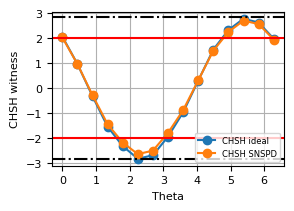

In [54]:
# make plot
plt.figure(figsize=(3,2))
plt.rcParams.update({'font.size': 8})
plt.plot(theta_vec,CHSH1_ideal,'o-',label = 'CHSH ideal')
plt.plot(theta_vec,CHSH1_snspd,'o-',label = 'CHSH SNSPD')
plt.grid(which='major',axis='both')
plt.rcParams.update({'font.size': 6})
plt.legend()
plt.axhline(y=2, color='r', linestyle='-')
plt.axhline(y=-2, color='r', linestyle='-')
plt.axhline(y=np.sqrt(2)*2, color='k', linestyle='-.')
plt.axhline(y=-np.sqrt(2)*2, color='k', linestyle='-.')
plt.xlabel('Theta')
plt.ylabel('CHSH witness')